In [38]:
import chess.pgn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl


In [39]:
input_dir = "/home/vandy/Work/MATH6310/blunder-analysis/data/silver/"
pl.read_parquet_schema(f"{input_dir}/*.parquet")

Schema([('game_id', String),
        ('offset', Int64),
        ('site', String),
        ('white_elo', Int64),
        ('black_elo', Int64),
        ('white_rating_diff', Int64),
        ('black_rating_diff', Int64),
        ('eco', String),
        ('time_control', Int64),
        ('game_time', Int64),
        ('increment', Int64),
        ('result', Int64),
        ('termination', String),
        ('turn', Boolean),
        ('move', String),
        ('fullmove_number', Int64),
        ('cp_score', Int64),
        ('winning_chance', Float64),
        ('drawing_chance', Float64),
        ('losing_chance', Float64),
        ('piece_moved', Int64),
        ('board_fen', String),
        ('is_check', Boolean),
        ('mate_in', Float64),
        ('clock', Float64),
        ('eval_delta', Int64)])

In [40]:
df = pl.scan_parquet(f"{input_dir}/*.parquet")

In [41]:
# Total number of games.
total_games = df.select(pl.col("game_id").n_unique()).collect()
total_moves = df.select(pl.len()).collect()
print(f"Total games: {total_games.head().item()}")
print(f"Total moves: {total_moves.head().item()}")

Total games: 187575
Total moves: 12540813


In [42]:
# Check if there are duplicate offset, game_id, turn, full_move_number combinations.
duplicate_check = (
    df.group_by(["offset", "game_id", "turn", "fullmove_number"])
    .agg(pl.len().alias("count"))
    .filter(pl.col("count") > 1)
)

# Materialize to inspect duplicates
duplicate_check.collect()

offset,game_id,turn,fullmove_number,count
i64,str,bool,i64,u32


In [43]:
time_control_counts = df.group_by("time_control").agg(pl.len().alias("count")).collect()
time_control_counts

time_control,count
i64,u32
3,1682068
4,6060220
1,3784
2,56129
5,4738612


In [44]:
MULTIPLIER = -0.00368208  # https://github.com/lichess-org/lila/pull/11148
winning_chance_judgements = [
    (0.3, "Blunder"),
    (0.2, "Mistake"),
    (0.1, "Inaccuracy"),
]

In [45]:
# winning_chance_lc = 2 / (1 + math.exp(MULTIPLIER * pl.col("cp_score")) - 1)
winning_chance_lc = 2 / (1 + (MULTIPLIER * pl.col("cp_score")).exp()) - 1
winning_chance_lc_prev = 2 / (1 + (MULTIPLIER * (pl.col("cp_score") - pl.col("eval_delta"))).exp()) - 1
winning_chance_lc_delta = (winning_chance_lc - winning_chance_lc_prev).abs()

blunder_threshold = 0.3
mistake_threshold = 0.2
inaccuracy_threshold = 0.1

In [46]:
judgement = pl.Enum(["Inaccuracy", "Mistake", "Blunder"])
time_control_type = pl.Enum(chess.pgn.TimeControlType._member_names_)
piece_type = pl.Enum(["PAWN", "KNIGHT", "BISHOP", "ROOK", "QUEEN", "KING"])

In [47]:
games_enriched = df.with_columns(
    (
        pl.when(winning_chance_lc_delta >= blunder_threshold)
        .then(pl.lit("Blunder"))
        .when(winning_chance_lc_delta >= mistake_threshold)
        .then(pl.lit("Mistake"))
        .when(winning_chance_lc_delta >= inaccuracy_threshold)
        .then(pl.lit("Inaccuracy"))
        .otherwise(None)
        .cast(dtype=judgement)
    ).alias("judgement"),
    pl.when(pl.col("time_control") == 0)
    .then(pl.lit("UNKNOWN"))
    .when(pl.col("time_control") == 1)
    .then(pl.lit("UNLIMITED"))
    .when(pl.col("time_control") == 2)
    .then(pl.lit("STANDARD"))
    .when(pl.col("time_control") == 3)
    .then(pl.lit("RAPID"))
    .when(pl.col("time_control") == 4)
    .then(pl.lit("BLITZ"))
    .when(pl.col("time_control") == 5)
    .then(pl.lit("BULLET"))
    .otherwise(None)
    .cast(dtype=time_control_type)
    .alias("time_control_type"),
    pl.when(pl.col("piece_moved") == chess.PAWN)
    .then(pl.lit("PAWN"))
    .when(pl.col("piece_moved") == chess.KNIGHT)
    .then(pl.lit("KNIGHT"))
    .when(pl.col("piece_moved") == chess.BISHOP)
    .then(pl.lit("BISHOP"))
    .when(pl.col("piece_moved") == chess.ROOK)
    .then(pl.lit("ROOK"))
    .when(pl.col("piece_moved") == chess.QUEEN)
    .then(pl.lit("QUEEN"))
    .when(pl.col("piece_moved") == chess.KING)
    .then(pl.lit("KING"))
    .otherwise(None)
    .cast(dtype=piece_type)
    .alias("piece_type"),
)

In [48]:
games_enriched = games_enriched.with_columns(
    pl.when(pl.col("turn")).then("white_elo").otherwise("black_elo").alias("player_elo"),
)

games_enriched = games_enriched.with_columns(
    pl.col("player_elo").cut(breaks=range(800, 2701, 200), include_breaks=True).alias("elo_bin"),
)

In [49]:
games_enriched.collect_schema()

Schema([('game_id', String),
        ('offset', Int64),
        ('site', String),
        ('white_elo', Int64),
        ('black_elo', Int64),
        ('white_rating_diff', Int64),
        ('black_rating_diff', Int64),
        ('eco', String),
        ('time_control', Int64),
        ('game_time', Int64),
        ('increment', Int64),
        ('result', Int64),
        ('termination', String),
        ('turn', Boolean),
        ('move', String),
        ('fullmove_number', Int64),
        ('cp_score', Int64),
        ('winning_chance', Float64),
        ('drawing_chance', Float64),
        ('losing_chance', Float64),
        ('piece_moved', Int64),
        ('board_fen', String),
        ('is_check', Boolean),
        ('mate_in', Float64),
        ('clock', Float64),
        ('eval_delta', Int64),
        ('judgement', Enum(categories=['Inaccuracy', 'Mistake', 'Blunder'])),
        ('time_control_type',
         Enum(categories=['UNKNOWN', 'UNLIMITED', 'STANDARD', 'RAPID', 'BLITZ', 'BULL

In [50]:
# Count moves per judgement
counts = games_enriched.group_by(
    "time_control_type",
    "elo_bin",
    "judgement",
).agg(
    pl.len().alias("count"),
)

# Total moves per bin
totals = games_enriched.group_by("time_control_type", "elo_bin").agg(
    pl.len().alias("total_in_bin"),
)

# Compute *mean proportion* per judgement per bin
result = (
    counts.join(totals, on=["time_control_type", "elo_bin"])
    .with_columns(
        (pl.col("count") / pl.col("total_in_bin")).alias("mean_count"),
    )
    .sort(["time_control_type", "elo_bin", "judgement"])
)

# result = result.drop_nulls("judgement")
result_pivoted = result.collect().pivot(on="judgement", values="mean_count", index=["time_control_type", "elo_bin"])
result_pivoted

time_control_type,elo_bin,null,Blunder,Inaccuracy,Mistake
enum,struct[2],f64,f64,f64,f64
"""UNLIMITED""","{1200.0,""(1000, 1200]""}",0.9375,0.0625,null,null
"""UNLIMITED""","{1400.0,""(1200, 1400]""}",0.813953,0.093023,0.062016,0.031008
"""UNLIMITED""","{1600.0,""(1400, 1600]""}",0.79078,0.049645,0.088652,0.070922
"""UNLIMITED""","{1800.0,""(1600, 1800]""}",0.767857,0.059524,0.134921,0.037698
"""UNLIMITED""","{2000.0,""(1800, 2000]""}",0.803781,0.052803,0.104954,0.038462
…,…,…,…,…,…
"""BULLET""","{2000.0,""(1800, 2000]""}",0.771592,0.069094,0.114305,0.045008
"""BULLET""","{2200.0,""(2000, 2200]""}",0.780899,0.064558,0.111274,0.043268
"""BULLET""","{2400.0,""(2200, 2400]""}",0.793665,0.058584,0.107202,0.04055


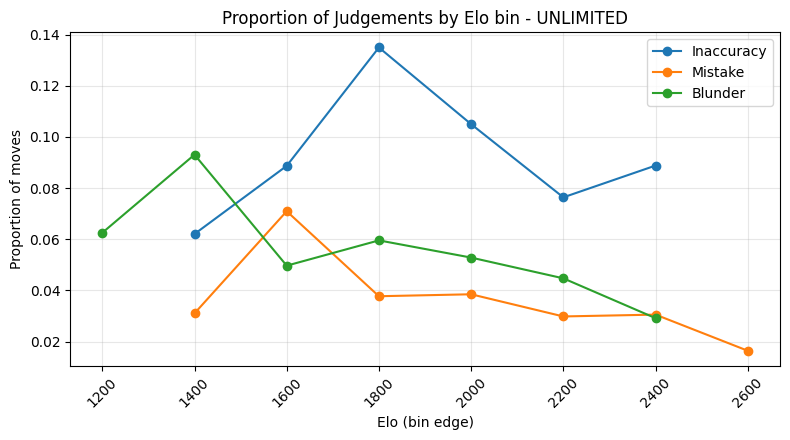

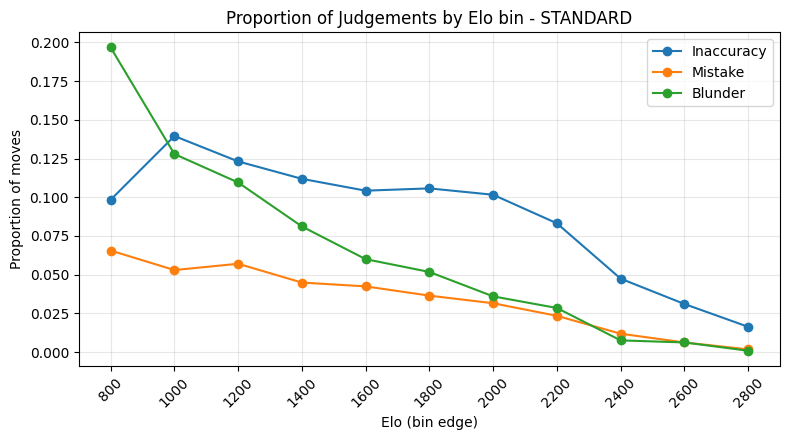

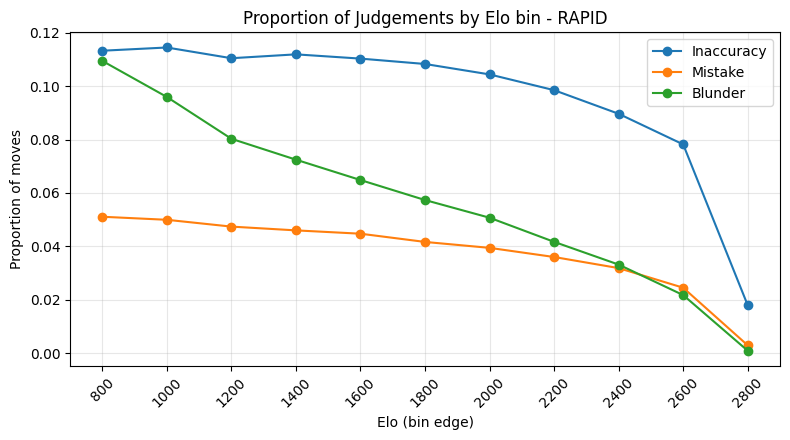

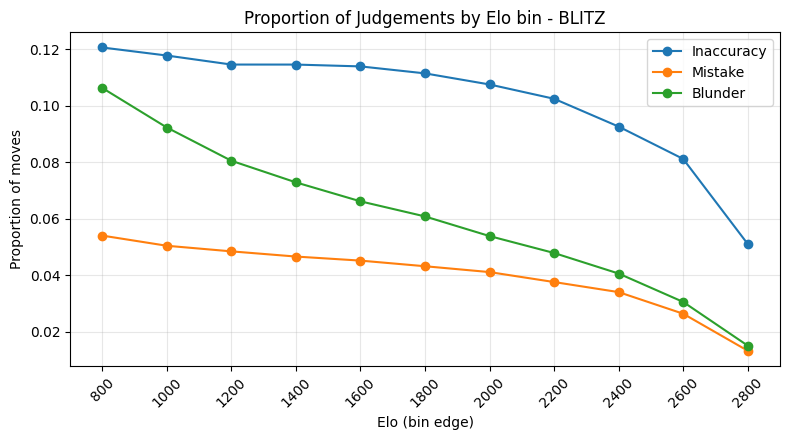

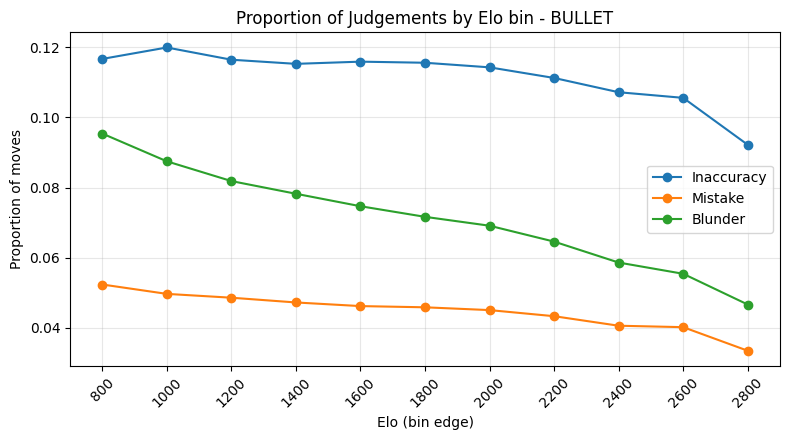

In [51]:
# result_pivoted should already exist from earlier cells
# convert struct elo_bin -> numeric edge and get a pandas view for plotting
result_pivoted_unset = result_pivoted.unnest("elo_bin")  # polars DataFrame from earlier cell

# get distinct time_control values preserving order
time_controls = list(dict.fromkeys(result_pivoted_unset.select("time_control_type").to_series().to_list()))

for tc in time_controls:
    # filter by time_control and select the plotting columns
    sub = result_pivoted_unset.filter(pl.col("time_control_type") == tc).select(
        ["breakpoint", "Inaccuracy", "Mistake", "Blunder"],
    )
    pdf = sub.to_pandas()

    # replace inf with a sensible finite x (last finite + bin width 200)
    x = pdf["breakpoint"].to_numpy(dtype=float)
    finite_mask = np.isfinite(x)
    if not finite_mask.all():
        max_finite = x[finite_mask].max()
        x[~finite_mask] = max_finite + 200
    pdf["x"] = x

    # sort by x and plot
    pdf = pdf.sort_values("x")

    plt.figure(figsize=(8, 4.5))
    plt.plot(pdf["x"], pdf.get("Inaccuracy", pd.Series(np.zeros(len(pdf)))), marker="o", label="Inaccuracy")
    plt.plot(pdf["x"], pdf.get("Mistake", pd.Series(np.zeros(len(pdf)))), marker="o", label="Mistake")
    plt.plot(pdf["x"], pdf.get("Blunder", pd.Series(np.zeros(len(pdf)))), marker="o", label="Blunder")

    plt.xlabel("Elo (bin edge)")
    plt.xticks(pdf["x"], rotation=45)
    plt.ylabel("Proportion of moves")
    plt.title(f"Proportion of Judgements by Elo bin - {tc}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [52]:
time_control_proportions = (
    games_enriched.group_by("time_control_type", "judgement")
    .agg(pl.len().alias("count"))
    .sort(
        "time_control_type",
        "judgement",
    )
    .with_columns(
        pl.col("count").sum().over("time_control_type").alias("total"),
    )
    .with_columns(
        (pl.col("count") / pl.col("total")).alias("proportion"),
    )
    .drop_nulls("judgement")
    .collect()
    .pivot(
        on="judgement",
        values="proportion",
        index=["time_control_type"],
    )
)

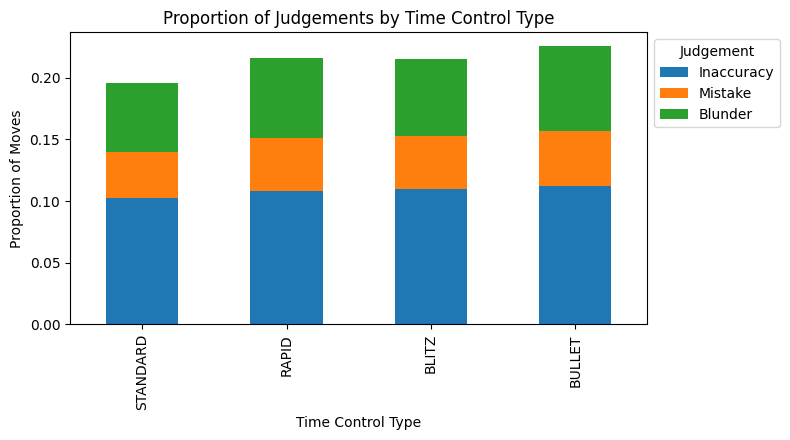

In [53]:
# Plot stacked bar chart of time control proportions, set the x-axis labels to time control types.
time_control_proportions_pd = time_control_proportions.filter(pl.col("time_control_type") > "UNLIMITED").to_pandas()
time_control_proportions_pd.plot(kind="bar", stacked=True, figsize=(8, 4.5), x="time_control_type")
plt.ylabel("Proportion of Moves")
plt.xlabel("Time Control Type")
plt.title("Proportion of Judgements by Time Control Type")
plt.legend(title="Judgement", bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [54]:
piece_proportions = (
    games_enriched.group_by("piece_type", "judgement")
    .agg(pl.len().alias("count"))
    .sort(
        "piece_type",
        "judgement",
    )
    .with_columns(
        pl.col("count").sum().over("piece_type").alias("total"),
    )
    .with_columns(
        (pl.col("count") / pl.col("total")).alias("proportion"),
    )
    .drop_nulls("judgement")
    .filter(pl.col("judgement").is_in(["Inaccuracy"]))
    .collect()
    .pivot(
        on="judgement",
        values="proportion",
        index=["piece_type"],
    )
    # .sort(pl.col("Inaccuracy") + pl.col("Mistake") + pl.col("Blunder"))
)

In [55]:
piece_proportions

piece_type,Inaccuracy
enum,f64
"""PAWN""",0.116953
"""KNIGHT""",0.113886
"""BISHOP""",0.125611
"""ROOK""",0.104208
"""QUEEN""",0.120545
"""KING""",0.071302


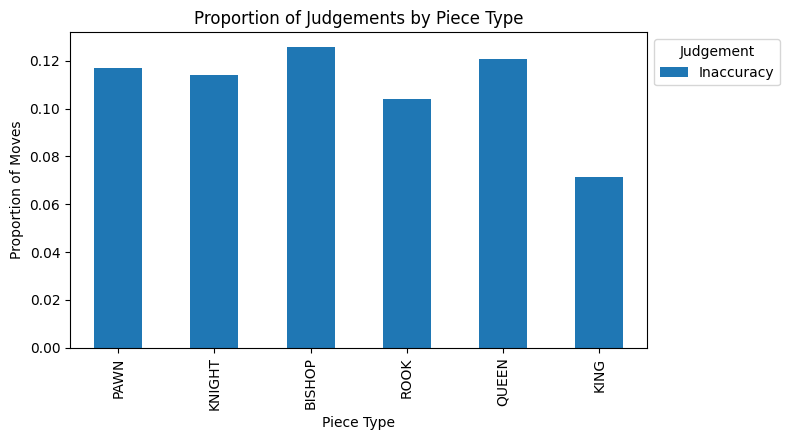

In [56]:
# Plot stacked bar chart of time control proportions, set the x-axis labels to time control types.
piece_proportions_pd = piece_proportions.to_pandas()
piece_proportions_pd.plot(kind="bar", stacked=True, figsize=(8, 4.5), x="piece_type")
plt.ylabel("Proportion of Moves")
plt.xlabel("Piece Type")
plt.title("Proportion of Judgements by Piece Type")
plt.legend(title="Judgement", bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [57]:
games_w_tr = (
    games_enriched.with_columns(
        pl.col("clock").shift(1).over("offset", "game_id", "turn", order_by="fullmove_number").alias("start_clock"),
    )
    .with_columns(
        (pl.col("start_clock") + pl.col("increment") - pl.col("clock")).alias("clock_delta"),
    )
    .with_columns(
        (pl.col("clock_delta") / (pl.col("start_clock") + pl.col("increment"))).fill_null(0).alias("time_ratio"),
    )
)

clock_deltas = games_w_tr.filter(pl.col("time_control_type") == "BULLET")

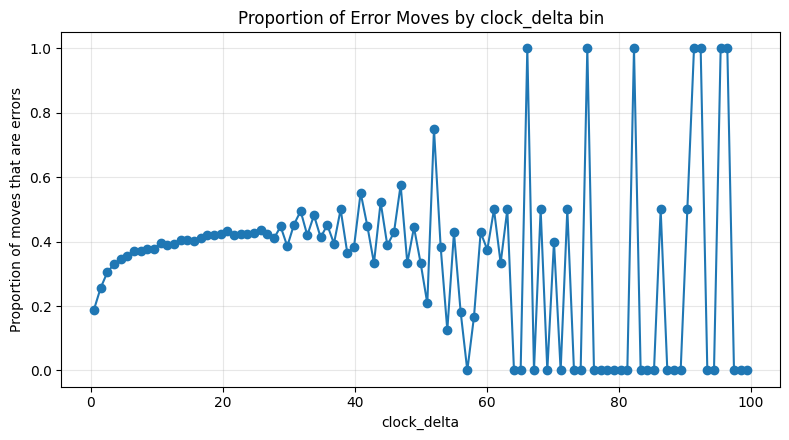

In [58]:
# Stream time_ratio values with collect_batches and build an incremental histogram
# Adjust bins as needed (here we assume most time_ratio values are in [0, 1])
bins = np.linspace(0.0, 100, 100)
counts_total = np.zeros(len(bins) - 1, dtype=int)
counts_errors = np.zeros(len(bins) - 1, dtype=int)

# clock_deltas is a LazyFrame; select the time_ratio and judgement columns and stream batches.
# collect_batches yields polars.DataFrame chunks (streamed evaluation).
for batch in clock_deltas.select([pl.col("clock_delta"), pl.col("judgement")]).collect_batches(chunk_size=10000):
    # batch is a polars.DataFrame for this chunk
    arr = batch["clock_delta"].to_numpy()
    jud = batch["judgement"].to_numpy()
    # keep only finite clock_delta values and corresponding judgements
    finite_mask = np.isfinite(arr)
    if not finite_mask.any():
        continue
    arr = arr[finite_mask]
    jud = jud[finite_mask]
    # accumulate total counts
    hist_total, _ = np.histogram(arr, bins=bins)
    counts_total += hist_total
    # accumulate error counts where judgement is populated (not None)
    # Note: depending on polars version jud may be dtype object with None for nulls
    error_mask = [x is not None for x in jud]
    # error_mask = [x == "Blunder" for x in jud]
    if any(error_mask):
        hist_errors, _ = np.histogram(arr[error_mask], bins=bins)
        counts_errors += hist_errors

# Plot stacked bar chart: non-error (total - errors) and errors
bin_centers = (bins[:-1] + bins[1:]) / 2.0
# plt.figure(figsize=(8, 4.5))
# plt.bar(bin_centers[:50], counts_errors[:50], width=(bins[1] - bins[0]), align="center", label="Error moves (judgement)")
# plt.bar(
#     bin_centers[:50],
#     counts_total[:50] - counts_errors[:50],
#     width=(bins[1] - bins[0]),
#     bottom=counts_errors[:50],
#     align="center",
#     label="Non-error moves",
# )
# plt.xlabel("clock_delta")
# plt.ylabel("count")
# plt.title("Histogram of clock_delta (streamed) — error vs non-error moves")
# plt.legend()
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

# Additionally, show proportion of errors per bin
total_per_bin = counts_total.copy()
with np.errstate(divide="ignore", invalid="ignore"):
    prop_errors = np.divide(
        counts_errors,
        total_per_bin,
        out=np.zeros_like(counts_errors, dtype=float),
        where=total_per_bin > 0,
    )
plt.figure(figsize=(8, 4.5))
plt.plot(bin_centers, prop_errors, marker="o")
plt.xlabel("clock_delta")
plt.ylabel("Proportion of moves that are errors")
plt.title("Proportion of Error Moves by clock_delta bin")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# If you want a normalized histogram (proportions) for the counts, normalize counts_total or counts_errors accordingly.

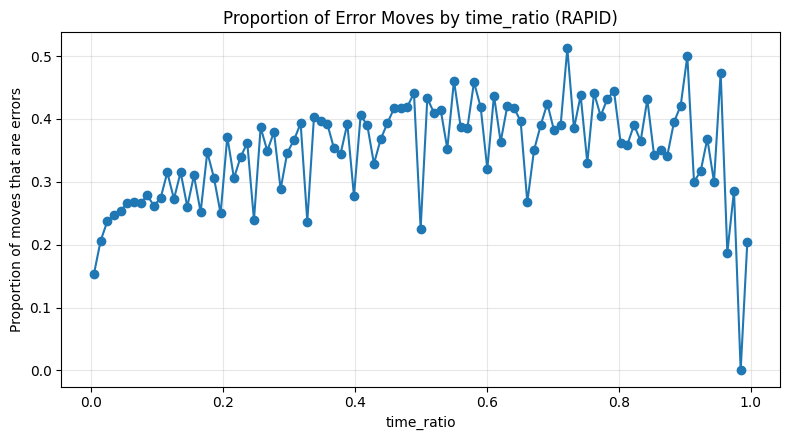

In [59]:
# Stream time_ratio values with collect_batches and build an incremental histogram
# Adjust bins as needed (here we assume most time_ratio values are in [0, 1])
bins = np.linspace(0.0, 1, 100)
counts_total = np.zeros(len(bins) - 1, dtype=int)
counts_errors = np.zeros(len(bins) - 1, dtype=int)

# clock_deltas is a LazyFrame; select the time_ratio and judgement columns and stream batches.
# collect_batches yields polars.DataFrame chunks (streamed evaluation).
for batch in clock_deltas.select([pl.col("time_ratio"), pl.col("judgement")]).collect_batches(chunk_size=10000):
    # batch is a polars.DataFrame for this chunk
    arr = batch["time_ratio"].to_numpy()
    jud = batch["judgement"].to_numpy()
    # keep only finite time_ratio values and corresponding judgements
    finite_mask = np.isfinite(arr)
    if not finite_mask.any():
        continue
    arr = arr[finite_mask]
    jud = jud[finite_mask]
    # accumulate total counts
    hist_total, _ = np.histogram(arr, bins=bins)
    counts_total += hist_total
    # accumulate error counts where judgement is populated (not None)
    # Note: depending on polars version jud may be dtype object with None for nulls
    error_mask = [x is not None for x in jud]
    # error_mask = [x == "Blunder" for x in jud]
    if any(error_mask):
        hist_errors, _ = np.histogram(arr[error_mask], bins=bins)
        counts_errors += hist_errors

# Plot stacked bar chart: non-error (total - errors) and errors
bin_centers = (bins[:-1] + bins[1:]) / 2.0
# plt.figure(figsize=(8, 4.5))
# plt.bar(bin_centers[:50], counts_errors[:50], width=(bins[1] - bins[0]), align="center", label="Error moves (judgement)")
# plt.bar(
#     bin_centers[:50],
#     counts_total[:50] - counts_errors[:50],
#     width=(bins[1] - bins[0]),
#     bottom=counts_errors[:50],
#     align="center",
#     label="Non-error moves",
# )
# plt.xlabel("time_ratio")
# plt.ylabel("count")
# plt.title("Histogram of time_ratio (streamed) — error vs non-error moves")
# plt.legend()
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

# Additionally, show proportion of errors per bin
total_per_bin = counts_total.copy()
with np.errstate(divide="ignore", invalid="ignore"):
    prop_errors = np.divide(
        counts_errors,
        total_per_bin,
        out=np.zeros_like(counts_errors, dtype=float),
        where=total_per_bin > 0,
    )
plt.figure(figsize=(8, 4.5))
plt.plot(bin_centers, prop_errors, marker="o")
plt.xlabel("time_ratio")
plt.ylabel("Proportion of moves that are errors")
plt.title("Proportion of Error Moves by time_ratio (RAPID)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# If you want a normalized histogram (proportions) for the counts, normalize counts_total or counts_errors accordingly.

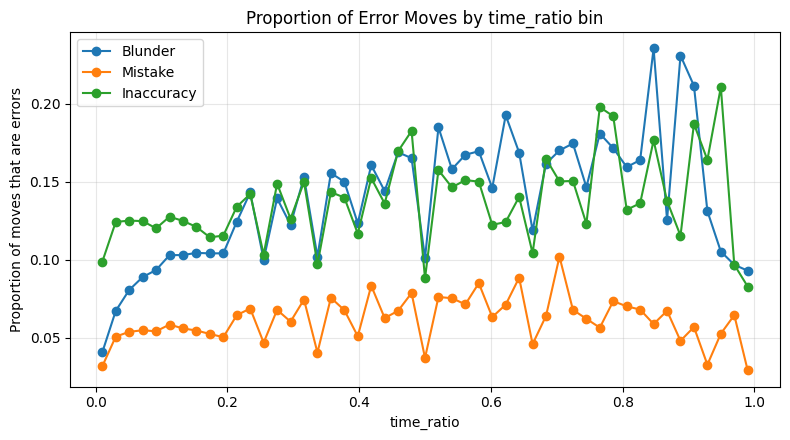

In [60]:
# Stream time_ratio values with collect_batches and build an incremental histogram
# Adjust bins as needed (here we assume most time_ratio values are in [0, 1])
bins = np.linspace(0.0, 1.0, 50)
counts_total = np.zeros(len(bins) - 1, dtype=int)
counts_blunders = np.zeros(len(bins) - 1, dtype=int)
counts_mistake = np.zeros(len(bins) - 1, dtype=int)
counts_inaccuracy = np.zeros(len(bins) - 1, dtype=int)

# clock_deltas is a LazyFrame; select the time_ratio and judgement columns and stream batches.
# collect_batches yields polars.DataFrame chunks (streamed evaluation).
for batch in clock_deltas.select([pl.col("time_ratio"), pl.col("judgement")]).collect_batches(chunk_size=10000):
    # batch is a polars.DataFrame for this chunk
    arr = batch["time_ratio"].to_numpy()
    jud = batch["judgement"].to_numpy()
    # keep only finite time_ratio values and corresponding judgements
    finite_mask = np.isfinite(arr)
    if not finite_mask.any():
        continue
    arr = arr[finite_mask]
    jud = jud[finite_mask]
    # accumulate total counts
    hist_total, _ = np.histogram(arr, bins=bins)
    counts_total += hist_total
    # accumulate error counts where judgement is populated (not None)
    # Note: depending on polars version jud may be dtype object with None for nulls
    blunder_mask = [x == "Blunder" for x in jud]
    mistake_mask = [x == "Mistake" for x in jud]
    inaccuracy_mask = [x == "Inaccuracy" for x in jud]
    # error_mask = [x == "Blunder" for x in jud]
    if any(blunder_mask):
        hist_blunders, _ = np.histogram(arr[blunder_mask], bins=bins)
        counts_blunders += hist_blunders
    if any(mistake_mask):
        hist_mistakes, _ = np.histogram(arr[mistake_mask], bins=bins)
        counts_mistake += hist_mistakes
    if any(inaccuracy_mask):
        hist_inaccuracies, _ = np.histogram(arr[inaccuracy_mask], bins=bins)
        counts_inaccuracy += hist_inaccuracies

# Plot stacked bar chart: non-error (total - errors) and errors
bin_centers = (bins[:-1] + bins[1:]) / 2.0

# Additionally, show proportion of errors per bin
total_per_bin = counts_total.copy()
with np.errstate(divide="ignore", invalid="ignore"):
    prop_blunders = np.divide(
        counts_blunders,
        total_per_bin,
        out=np.zeros_like(counts_blunders, dtype=float),
        where=total_per_bin > 0,
    )
    prop_mistake = np.divide(
        counts_mistake,
        total_per_bin,
        out=np.zeros_like(counts_mistake, dtype=float),
        where=total_per_bin > 0,
    )
    prop_inaccuracy = np.divide(
        counts_inaccuracy,
        total_per_bin,
        out=np.zeros_like(counts_inaccuracy, dtype=float),
        where=total_per_bin > 0,
    )

plt.figure(figsize=(8, 4.5))
plt.plot(bin_centers, prop_blunders, marker="o", label="Blunder")
plt.plot(bin_centers, prop_mistake, marker="o", label="Mistake")
plt.plot(bin_centers, prop_inaccuracy, marker="o", label="Inaccuracy")
plt.xlabel("time_ratio")
plt.ylabel("Proportion of moves that are errors")
plt.title("Proportion of Error Moves by time_ratio bin")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# If you want a normalized histogram (proportions) for the counts, normalize counts_total or counts_errors accordingly.

In [61]:
# # Clip log inputs to avoid log(0)
# eps = 1e-12
# wc = ((1 / pl.col("winning_chance").clip(eps)) - 1).clip(eps)
# lc = ((1 / pl.col("losing_chance").clip(eps)) - 1).clip(eps)
# wdl_contempt = (
#     binned.with_columns(
#         wc.alias("wc"),
#         lc.alias("lc"),
#     )
#     .with_columns(
#         (wc.log()).alias("wc_log"),
#         (lc.log()).alias("lc_log"),
#     )
#     .with_columns(
#         ((2 / (pl.col("wc_log") + pl.col("lc_log"))) ** 2).alias("wdl_contempt"),
#     )
# )

In [62]:
# # batch = wdl_contempt.filter((pl.col("winning_chance") > 0.7) & (pl.col("winning_chance") < 0.99) ).select(["winning_chance", "drawing_chance", "losing_chance", "wc_log", "lc_log", "wdl_contempt"]).collect_batches(chunk_size=20)
# batch = wdl_contempt.select(
#     ["cp_score","winning_chance", "drawing_chance", "losing_chance", "wc", "lc", "wc_log", "lc_log", "wdl_contempt"]
# ).collect_batches(chunk_size=100)

In [63]:
# s = pl.col("winning_chance").clip(eps) + pl.col("losing_chance").clip(eps)
# wdl_contempt2 = binned.with_columns(
#     ((4 * pl.col("winning_chance").clip(eps) * pl.col("losing_chance").clip(eps)) / (s)).alias("wdl_contempt"),
# )
# batch = wdl_contempt2.select(["winning_chance", "drawing_chance", "losing_chance", "wdl_contempt"]).collect_batches(
#     chunk_size=20
# )

In [64]:
# wc = (pl.col("winning_chance").clip(eps)) / (pl.col("winning_chance").clip(eps) + pl.col("losing_chance").clip(eps))
# lc = (pl.col("losing_chance").clip(eps)) / (pl.col("winning_chance").clip(eps) + pl.col("losing_chance").clip(eps))
# wdl_contempt3 = binned.with_columns(
#     wc.alias("wc"),
#     lc.alias("lc"),
#     (wc * (wc.log())).alias("wc_log"),
#     (lc * (lc.log())).alias("lc_log"),
# ).with_columns(
#     ((pl.col("winning_chance") + pl.col("losing_chance")) * (-1 * (pl.col("wc_log") + pl.col("lc_log")))).alias(
#         "wdl_contempt"
#     ),
# )
# batch = wdl_contempt3.select(
#     ["winning_chance", "drawing_chance", "losing_chance", "wc", "lc", "wc_log", "lc_log", "wdl_contempt"]
# ).collect_batches(chunk_size=20)

In [65]:
# alpha = 1
# sigma = 0.1
# sharpness = (pl.col("winning_chance") + pl.col("losing_chance")).pow(alpha) * (
#     ((pl.col("winning_chance") - 0.5).pow(2) + (pl.col("losing_chance") - 0.5).pow(2)).mul(-1 / (2 * sigma**2)).exp()
# )

# games_w_sharpness = games_w_tr.with_columns(
#     sharpness.alias("sharpness"),
# )

# batch = games_w_sharpness.select(
#     ["winning_chance", "drawing_chance", "losing_chance", "sharpness"],
# ).collect_batches(chunk_size=80)

In [66]:
games_w_sharpness = games_w_tr.with_columns((pl.col("winning_chance") + pl.col("losing_chance")).alias("total_chance"))

In [67]:
sharpness_df = games_w_sharpness
sharpness_df.select("fullmove_number", "cp_score", "eval_delta", "player_elo").describe()

statistic,fullmove_number,cp_score,eval_delta,player_elo
str,f64,f64,f64,f64
"""count""",1.2540813e7,1.2540813e7,1.2540813e7,1.2540813e7
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",20.661477,218.682714,29.758093,1706.729065
"""std""",14.936899,20796.861362,13004.480556,401.786034
"""min""",1.0,-100000.0,-199998.0,400.0
"""25%""",9.0,-160.0,-23.0,1436.0
"""50%""",18.0,22.0,0.0,1725.0
"""75%""",29.0,204.0,23.0,1982.0
"""max""",222.0,100000.0,199998.0,3288.0


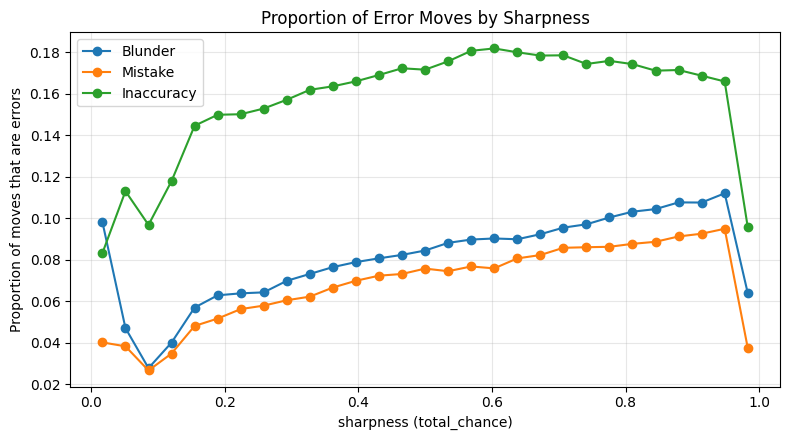

In [68]:
# Stream time_ratio values with collect_batches and build an incremental histogram
# Adjust bins as needed (here we assume most time_ratio values are in [0, 1])
bins = np.linspace(0.0, 1, 30)
counts_total = np.zeros(len(bins) - 1, dtype=int)
counts_blunders = np.zeros(len(bins) - 1, dtype=int)
counts_mistake = np.zeros(len(bins) - 1, dtype=int)
counts_inaccuracy = np.zeros(len(bins) - 1, dtype=int)

# clock_deltas is a LazyFrame; select the wdl_contempt and judgement columns and stream batches.
# collect_batches yields polars.DataFrame chunks (streamed evaluation).
for batch in sharpness_df.select([pl.col("total_chance"), pl.col("judgement")]).collect_batches(chunk_size=10000):
    # batch is a polars.DataFrame for this chunk
    arr = batch["total_chance"].to_numpy()
    jud = batch["judgement"].to_numpy()
    # keep only finite total_chance values and corresponding judgements
    finite_mask = np.isfinite(arr)
    if not finite_mask.any():
        continue
    arr = arr[finite_mask]
    jud = jud[finite_mask]
    # accumulate total counts
    hist_total, _ = np.histogram(arr, bins=bins)
    counts_total += hist_total
    # accumulate error counts where judgement is populated (not None)
    # Note: depending on polars version jud may be dtype object with None for nulls
    blunder_mask = [x == "Blunder" for x in jud]
    mistake_mask = [x == "Mistake" for x in jud]
    inaccuracy_mask = [x == "Inaccuracy" for x in jud]
    # error_mask = [x == "Blunder" for x in jud]
    if any(blunder_mask):
        hist_blunders, _ = np.histogram(arr[blunder_mask], bins=bins)
        counts_blunders += hist_blunders
    if any(mistake_mask):
        hist_mistakes, _ = np.histogram(arr[mistake_mask], bins=bins)
        counts_mistake += hist_mistakes
    if any(inaccuracy_mask):
        hist_inaccuracies, _ = np.histogram(arr[inaccuracy_mask], bins=bins)
        counts_inaccuracy += hist_inaccuracies

# Plot stacked bar chart: non-error (total - errors) and errors
bin_centers = (bins[:-1] + bins[1:]) / 2.0

# Additionally, show proportion of errors per bin
total_per_bin = counts_total.copy()
with np.errstate(divide="ignore", invalid="ignore"):
    prop_blunders = np.divide(
        counts_blunders,
        total_per_bin,
        out=np.zeros_like(counts_blunders, dtype=float),
        where=total_per_bin > 0,
    )
    prop_mistake = np.divide(
        counts_mistake,
        total_per_bin,
        out=np.zeros_like(counts_mistake, dtype=float),
        where=total_per_bin > 0,
    )
    prop_inaccuracy = np.divide(
        counts_inaccuracy,
        total_per_bin,
        out=np.zeros_like(counts_inaccuracy, dtype=float),
        where=total_per_bin > 0,
    )

plt.figure(figsize=(8, 4.5))
plt.plot(bin_centers, prop_blunders, marker="o", label="Blunder")
plt.plot(bin_centers, prop_mistake, marker="o", label="Mistake")
plt.plot(bin_centers, prop_inaccuracy, marker="o", label="Inaccuracy")
plt.xlabel("sharpness (total_chance)")
plt.ylabel("Proportion of moves that are errors")
plt.title("Proportion of Error Moves by Sharpness")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# If you want a normalized histogram (proportions) for the counts, normalize counts_total or counts_errors accordingly.

In [69]:
piece_layers = ["P", "N", "B", "R", "Q", "K", "p", "n", "b", "r", "q", "k"]
layer_idx = {p: i for i, p in enumerate(piece_layers)}
tensor_size = len(piece_layers) * 64
tensor_cols = [f"fen_{p}_{sq:02d}" for p in piece_layers for sq in range(64)]


def fen_to_bitboard(board_fen: str) -> pl.Series:
    """Convert FEN to 12×8×8 bitboard tensor.

    Planes: [WP, WN, WB, WR, WQ, WK, BP, BN, BB, BR, BQ, BK]
    """
    import chess

    board = chess.Board(board_fen + " w - - 0 1")  # Complete minimal FEN

    bitboard = np.zeros((12, 8, 8), dtype=np.uint8)
    piece_map = board.piece_map()

    for square, piece in piece_map.items():
        rank, file = divmod(square, 8)
        plane_idx = (piece.piece_type - 1) + (0 if piece.color else 6)
        bitboard[plane_idx, rank, file] = 1

    return pl.Series(bitboard.flatten().tolist(), dtype=pl.UInt8)


games_fen_encoded = games_w_sharpness.with_columns(
    pl.col("board_fen").map_elements(fen_to_bitboard, return_dtype=pl.List(pl.UInt8)).alias("fen_tensor"),
).with_columns(pl.col("fen_tensor").list.to_array(768).alias("fen_tensor"))

In [70]:
games_fen_encoded.select(pl.len()).collect()

len
u32
12540813


In [71]:
games_fen_encoded.collect_schema()

Schema([('game_id', String),
        ('offset', Int64),
        ('site', String),
        ('white_elo', Int64),
        ('black_elo', Int64),
        ('white_rating_diff', Int64),
        ('black_rating_diff', Int64),
        ('eco', String),
        ('time_control', Int64),
        ('game_time', Int64),
        ('increment', Int64),
        ('result', Int64),
        ('termination', String),
        ('turn', Boolean),
        ('move', String),
        ('fullmove_number', Int64),
        ('cp_score', Int64),
        ('winning_chance', Float64),
        ('drawing_chance', Float64),
        ('losing_chance', Float64),
        ('piece_moved', Int64),
        ('board_fen', String),
        ('is_check', Boolean),
        ('mate_in', Float64),
        ('clock', Float64),
        ('eval_delta', Int64),
        ('judgement', Enum(categories=['Inaccuracy', 'Mistake', 'Blunder'])),
        ('time_control_type',
         Enum(categories=['UNKNOWN', 'UNLIMITED', 'STANDARD', 'RAPID', 'BLITZ', 'BULL

In [72]:
games_final = games_fen_encoded.select(
    [
        "game_id",
        "offset",
        "eco",
        "game_time",
        "increment",
        "result",
        "termination",
        "turn",
        "move",
        "fullmove_number",
        "cp_score",
        "winning_chance",
        "drawing_chance",
        "losing_chance",
        "piece_type",
        "is_check",
        "mate_in",
        "clock",
        "eval_delta",
        "judgement",
        "time_control_type",
        "player_elo",
        "time_ratio",
        "total_chance",
        "fen_tensor",
    ],
)

games_final.collect_schema()

Schema([('game_id', String),
        ('offset', Int64),
        ('eco', String),
        ('game_time', Int64),
        ('increment', Int64),
        ('result', Int64),
        ('termination', String),
        ('turn', Boolean),
        ('move', String),
        ('fullmove_number', Int64),
        ('cp_score', Int64),
        ('winning_chance', Float64),
        ('drawing_chance', Float64),
        ('losing_chance', Float64),
        ('piece_type',
         Enum(categories=['PAWN', 'KNIGHT', 'BISHOP', 'ROOK', 'QUEEN', 'KING'])),
        ('is_check', Boolean),
        ('mate_in', Float64),
        ('clock', Float64),
        ('eval_delta', Int64),
        ('judgement', Enum(categories=['Inaccuracy', 'Mistake', 'Blunder'])),
        ('time_control_type',
         Enum(categories=['UNKNOWN', 'UNLIMITED', 'STANDARD', 'RAPID', 'BLITZ', 'BULLET'])),
        ('player_elo', Int64),
        ('time_ratio', Float64),
        ('total_chance', Float64),
        ('fen_tensor', Array(UInt8, shape=(768

In [ ]:
games_final.sink_parquet(pl.PartitionByKey("/home/vandy/Work/MATH6310/blunder-analysis/data/gold", by="time_control_type", include_key=True), compression="lz4", statistics=True, row_group_size=5000)